In [1]:
import pickle
import json
import os
from datetime import datetime
import pandas as pd
from tqdm import tqdm
import regex as re
import nltk
import matplotlib.pyplot as plt

# Data cleaning

Main responsible Andreas

We get the data from https://the-eye.eu/redarcs/

The data comes in two files:
mbti_submissions contains all the post in the subreddit
mbti_comments contains all the comments in the subredit, keep in mind a comment can comment on another comment.

We then discard all file without flair or missing deleted authors 

In [8]:
#The data comes in zstd format, this script decompresses to jsonl

import zstandard as zstd
import os

def decompress_zst(input_file_name, output_file_name):
    # Check if the input file exists
    if not os.path.exists(input_file_name):
        print(f"Error: File {input_file_name} not found!")
        return

    # Check if the output file already exists
    if os.path.exists(output_file_name):
        overwrite = input(f"Warning: {output_file_name} already exists. Overwrite? (y/n): ")
        if overwrite.lower() != 'y':
            print("Decompression aborted.")
            return

    # Attempt to decompress the file
    try:
        with open(input_file_name, 'rb') as compressed:
            dctx = zstd.ZstdDecompressor()
            with open(output_file_name, 'wb') as destination:
                dctx.copy_stream(compressed, destination)
        print(f"Decompressed {input_file_name} to {output_file_name}")
    except Exception as e:
        print(f"Error during decompression: {e}")


input_file_name = os.path.join(os.getcwd(), "LargeData/mbti_comments.zst")
output_file_name = os.path.join(os.getcwd(), 'LargeData/mbti_comments.ndjson')
decompress_zst(input_file_name, output_file_name)
input_file_name = os.path.join(os.getcwd(), "LargeData/mbti_submissions.zst")
output_file_name = os.path.join(os.getcwd(), 'LargeData/mbti_submissions.ndjson')
decompress_zst(input_file_name, output_file_name)

Error: File c:\Users\Andre\OneDrive - Danmarks Tekniske Universitet\Social Data Science\Projekt_git\MBTI\LargeData/mbti_comments.zst not found!
Error: File c:\Users\Andre\OneDrive - Danmarks Tekniske Universitet\Social Data Science\Projekt_git\MBTI\LargeData/mbti_submissions.zst not found!


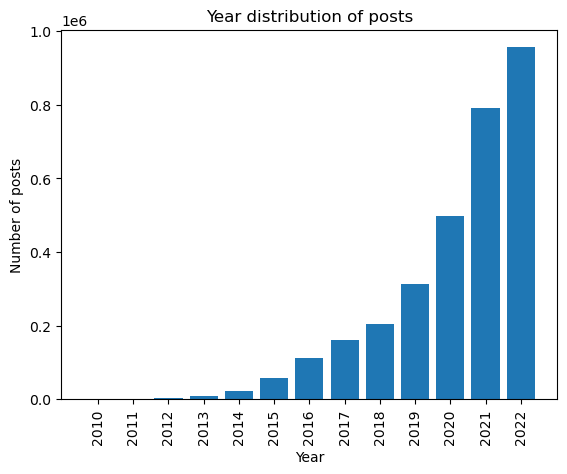

In [22]:
#Year distribution of posts
file_dir = "LargeData"
year_dict = {}
for load_file in ['mbti_comments.ndjson','mbti_submissions.ndjson']:
    with open(os.path.join(file_dir,load_file), encoding='utf-8') as f:
        for line in f:
            post=json.loads(line)
            year = datetime.utcfromtimestamp(int(post['created_utc'])).year
            if year in year_dict:
                year_dict[year]+=1
            else:
                year_dict[year]=1


plt.bar(year_dict.keys(),year_dict.values())
plt.xlabel('Year')
plt.ylabel('Number of posts')
plt.xticks(list(year_dict.keys()), rotation=90)
plt.title('Year distribution of posts')
plt.show()


# Data removal
Remove all data without author flair and not from 2022

In [3]:
flair_list = ["intp","intj","entp","entj","infj","infp","enfj","enfp","istj","isfj","estj","esfj","istp","isfp","estp","esfp"]

file_dir = "LargeData"

author_dict = {} #dict of who wrote each post

comment_list = [] #list of comments
submission_list = [] #list of submissions


#Load submisson ndjson file
for load_file in ['mbti_comments.ndjson','mbti_submissions.ndjson']:
    with open(os.path.join(file_dir,load_file), encoding='utf-8') as f:
        for line in f:
            post=json.loads(line)

            #Tings that will delete the comment
            if post["author"] == "[deleted]": #If the author is deleted
                continue
                print("Deleted author")

            #elif datetime.utcfromtimestamp(int(post['created_utc'])).year not in [2022]: #If the post is from 2022
            #    continue
            #    print("Wrong year")

            elif post['author_flair_css_class'] not in flair_list: #If the author has no flair
                continue
                print("No flair")
            
            elif post.get('body',"") == "" and post.get('selftext',"") == "": #If the post is removed or deleted
                continue
                print("No text")
            else:
                id = post['id']
                author = post['author']
                flair = post['author_flair_css_class']


                author_dict[id] = author

                parent_id=post.get("parent_id")
                if parent_id == None:
                    text=post["selftext"]
                    parents_author = None
                    submission_list.append({"id": id, "author": author, "flair": flair, "text": text, "parents_author": parents_author})
                else:
                    text=post["body"]
                    comment_list.append({"id": id, "author": author, "flair": flair, "text": text, "parent_id": parent_id})
                        





# Text cleaning
We tokenise the text remove stopwords and lemmatize it. 

In [4]:
#Clan text
from nltk.tokenize import word_tokenize
import nltk
import regex as re
def preprocess(text):
    text = re.sub(r'\'s','',text)
    text = re.sub(r'[^\w\s]','',text)
    text = text.lower()
    text = nltk.word_tokenize(text)
    text = [t for t in text if t not in nltk.corpus.stopwords.words('english')]
    text = [nltk.WordNetLemmatizer().lemmatize(t) for t in text]
    return text

# Make link list
We make a list where each entry represent and edge in our graph. 

In [5]:
#Make link list that can be used to make a graph
edge_list = []

for post in tqdm(comment_list):
    

    parents_author = author_dict.get(post["parent_id"][3:])

    #If the parent is deleted, skip
    if parents_author == None:
        continue

    #Process text
    text = preprocess(post["text"])

    #make dictionary
    edge = {"author":post["author"], "addressee":parents_author, "id":post["id"], "flair": post["flair"],"comment":text}

    edge_list.append(edge)


100%|██████████| 1782911/1782911 [1:33:56<00:00, 316.29it/s]  


In [8]:
#Save edge list
with open('LargeData/edges_all.pkl', 'wb') as outfile:
    pickle.dump(edge_list, outfile)
print(len(edge_list))

883472


In [9]:
with open('LargeData/submissions_all.pkl', 'wb') as outfile:
    pickle.dump(submission_list, outfile)
print(len(submission_list))

37312
